**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [1]:
# ! pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

#### read data

In [3]:
data = pd.read_csv('./data/retail_train.csv')
item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

#### Process features dataset

In [4]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [5]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

#### Split dataset for train, eval, test

In [6]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [7]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [8]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [9]:
# вывод разброса по пользователям и товарам
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [10]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


#### Prefilter items

In [11]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


#### Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


#### Init/train recommender

In [13]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

#### получить кандидатов

In [14]:
ACTUAL_COL = 'actual'
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [15]:
def get_recommendations(data:pd.DataFrame, user_col:str, recommend_model, top_n:int):
    """
    recommend_models' enum:
        recommender.get_own_recommendations
        recommender.get_als_recommendations
        recommender.get_similar_items_recommendation
        recommender.get_similar_users_recommendation
    """
    data[recommend_model.__name__[4:]] = data[user_col].apply(lambda x: recommend_model(x, N=top_n))

In [16]:
def calc_recall(df_data, top_k, columns=None):
    if columns is None:
        columns = df_data.columns[2:]
        
    for col_name in columns:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [17]:
N_PREDICT = 50 
get_recommendations(result_eval_matcher, USER_COL, recommender.get_own_recommendations, N_PREDICT)
get_recommendations(result_eval_matcher, USER_COL, recommender.get_als_recommendations, N_PREDICT)
get_recommendations(result_eval_matcher, USER_COL, recommender.get_similar_items_recommendation, N_PREDICT)
get_recommendations(result_eval_matcher, USER_COL, recommender.get_similar_users_recommendation, N_PREDICT)
result_eval_matcher.head(5)

,user_id,actual,own_recommendations,als_recommendations,similar_items_recommendation,similar_users_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[6533936, 1082212, 1037332, 824758, 962615, 85...","[824758, 826597, 9297615, 5577022, 907002, 983...","[974336, 949257, 940770, 1108776, 8090653, 102..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 916122, 933835, 866211, 1040807, 914...","[8090537, 5569845, 1044078, 985999, 951092, 81...","[9802756, 10342382, 1056212, 961889, 1052294, ..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[5569327, 891423, 944588, 1082627, 6391541, 84...","[1133826, 846550, 7025250, 999714, 8019845, 10...","[862535, 7467039, 7166756, 1073120, 1122844, 8..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 972416, 995598, 923600, 1138596, 10...","[878996, 933637, 1084036, 965267, 1042616, 108...","[948650, 5569845, 819308, 941361, 1074754, 110...","[7442505, 1015280, 1113675, 893362, 1075796, 1..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[998519, 894360, 7147142, 9338009, 896666, 939...","[1039627, 1100140, 7168890, 7168759, 1041688, ...","[5585510, 1044078, 949023, 8293385, 916993, 96...","[8069336, 852015, 924004, 868888, 7168759, 716..."


In [18]:
TOPK_RECALL = 50
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_recommendations', 0.06525657038145175),
 ('als_recommendations', 0.04873234596915972),
 ('similar_items_recommendation', 0.03280530083278264),
 ('similar_users_recommendation', 0.0072294982588503994)]

<span style="color:red">лучший recall дала модель ItemItemRecommender </span>

#### проверка влияния top-popular на recall для own_recommendations

In [19]:
overall_top_purchases = recommender.overall_top_purchases.copy()
recommender.overall_top_purchases = [999999]*N_PREDICT
get_recommendations(result_eval_matcher, USER_COL, recommender.get_own_recommendations, N_PREDICT)
sorted(calc_recall(result_eval_matcher, TOPK_RECALL, ['own_recommendations']), key=lambda x: x[1],reverse=True)

[('own_recommendations', 0.06018145687107224)]

In [20]:
recommender.overall_top_purchases = overall_top_purchases.copy()

<span style="color:red">на сколько процентов модель даёт лучшие результаты по recall для own_recommendations с дополнением top-popular </span>

In [21]:
(0.06525657038145175-0.06018145687107224) / 0.06525657038145175 * 100

7.77716861415388

#### Как зависит recall@k от k

In [22]:
COL_OWN_REC = 'own_recommendations' 
k_vals = [20, 50, 100, 200, 500]
result = []
for k in k_vals:
    get_recommendations(result_eval_matcher, USER_COL, recommender.get_own_recommendations, k)
    result.append(dict(calc_recall(result_eval_matcher, k, [COL_OWN_REC]))[COL_OWN_REC])

Text(0, 0.5, 'recall_at_k')

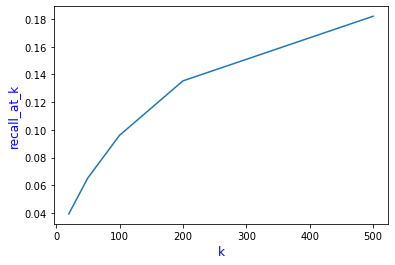

In [23]:
plt.plot(k_vals, result)
plt.xlabel('k', fontsize=12, color='blue')
plt.ylabel('recall_at_k', fontsize=12, color='blue')

<span style="color:red"> понятно, что чем больше количество рекомендаций, тем больше релевантных товаров будет в списке рекомендаций, т.е. тем больше будет recall. С увеличением к график recall замедляется. Значительно замедлился рост при к = 200. Т.е. разумным будет принять к равным 200, но такое большое количество рекомендаций не всегда необходимо, всё зависит от поставленной задачи </span>

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

#### Обучаем модель 2-ого уровня на выбранных кандидатах

Подготовка данных для трейна

In [24]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [25]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [26]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [27]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(5)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640
0,2070,928263


#### Check warm start

In [28]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


#### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1

In [29]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [30]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [31]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [32]:
df_ranker_train.target.value_counts()

0.0    99177
1.0     7795
Name: target, dtype: int64

In [33]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


#### Подготавливаем фичи для обучения модели

In [34]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

In [35]:
data_train_ranker.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


Фичи user_id: - Средний чек - Средняя сумма покупки 1 товара в каждой категории - Кол-во покупок в каждой категории - Частотность покупок раз/месяц - Долю покупок в выходные - Долю покупок утром/днем/вечером

Фичи item_id: - Кол-во покупок в неделю - Среднее кол-во покупок 1 товара в категории в неделю - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю) - Цена (Можно посчитать из retil_train.csv) - Цена / Средняя цена товара в категории

Фичи пары user_id - item_id - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id) - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю) - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

##### Фичи user_id

In [36]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [37]:
data_train_ranker_copy = data_train_ranker.copy()
data_train_ranker_copy = data_train_ranker_copy.merge(item_features, on='item_id', how='left')

# Кол-во покупок в каждой категории
cat_sales_count = data_train_ranker_copy.groupby(by=['user_id', 'department']).agg(user_cat_sales_count=('quantity','sum'))

# Сумма покупок в каждой категории
cat_sales_value = data_train_ranker_copy.groupby(by=['user_id', 'department']).agg(user_cat_sales_value=('sales_value','sum'))

df_ranker_train = df_ranker_train.merge(cat_sales_count, on=['user_id', 'department'], how='inner')
df_ranker_train = df_ranker_train.merge(cat_sales_value, on=['user_id', 'department'], how='inner')

# Средняя сумма покупки 1 товара в каждой категории
df_ranker_train['user_mean_item_price_in_cat'] = df_ranker_train.user_cat_sales_value.\
    div(df_ranker_train.user_cat_sales_count, axis=0)

# Средний чек
mean_sales_value = data_train_ranker_copy.groupby(by=['user_id', 'basket_id']).agg(user_mean_sales_value=('sales_value','sum')).\
    groupby(by=['user_id']).mean()
df_ranker_train = df_ranker_train.merge(mean_sales_value, on=['user_id'], how='inner')

df_ranker_train.sample(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_cat_sales_count,user_cat_sales_value,user_mean_item_price_in_cat,user_mean_sales_value
19890,2171,1029549,0.0,1075,GROCERY,National,COOKIES/CONES,SPECIALTY COOKIES,10 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,210.44,2.287391,41.824444
25269,928,5565802,0.0,135,GROCERY,National,FRZN POTATOES,FRZN FRENCH FRIES,28 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,38.63,2.033158,18.756923
76117,175,1104414,0.0,1075,GROCERY,National,CRACKERS/MISC BKD FD,SNACK CRACKERS,9.5 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54,79.32,1.468889,24.415000


In [38]:
data_train_ranker_copy

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,1232,GROCERY,National,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,1 DZ
2,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0,170,GROCERY,National,CANNED JUICES,FRUIT DRINKS: CANNED & GLASS (,128 OZ
3,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0,69,GROCERY,Private,FRZN VEGETABLE/VEG DSH,FRZN BAGGED VEGETABLES - PLAIN,16 OZ
4,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0,1425,MEAT-PCKGD,National,BACON,ECONOMY,1 LB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169610,222,41297772783,635,1120741,1,0.59,304,0.00,1716,91,0.0,0.0,69,GROCERY,Private,SOFT DRINKS,SFT DRNK 2 LITER BTL CARB INCL,2 LTR
169611,462,41297773713,635,993339,1,1.99,304,0.00,2040,91,0.0,0.0,69,GROCERY,Private,YOGURT,YOGURT NOT MULTI-PACKS,32 OZ
169612,462,41297773713,635,995242,1,1.00,304,-0.89,2040,91,0.0,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,
169613,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0,69,MEAT-PCKGD,Private,LUNCHMEAT,MISCELLANEOUS,8OZ


##### Фичи item_id

In [39]:
# Кол-во покупок в неделю
week_sales_count = round(data_train_ranker_copy.groupby(by=['item_id']).agg(item_week_sales_count=('quantity','sum')) / \
        data_train_ranker_copy.week_no.nunique(), 3)


# Среднее кол-во покупок 1 товара в категории в неделю
mean_week_sales_count = round(data_train_ranker_copy.groupby(by=['item_id', 'department']).agg(item_mean_week_sales_count=('quantity','sum'))  / \
        data_train_ranker_copy.week_no.nunique(), 3)

df_ranker_train = df_ranker_train.merge(week_sales_count, on=['item_id'], how='inner')
df_ranker_train = df_ranker_train.merge(mean_week_sales_count, on=['item_id', 'department'], how='inner')

df_ranker_train.sample(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_cat_sales_count,user_cat_sales_value,user_mean_item_price_in_cat,user_mean_sales_value,item_week_sales_count,item_mean_week_sales_count
61743,2360,906443,0.0,2209,MEAT-PCKGD,National,DINNER SAUSAGE,FRESH,19.76 OZ,25-34,...,Homeowner,Unknown,1,None/Unknown,2,5.00,2.50,21.367391,0.333,0.333
46550,1775,1090317,0.0,397,MEAT-PCKGD,National,FROZEN MEAT,FRZN BREADED PREPARED CHICK,24 OZ,45-54,...,Homeowner,2 Adults Kids,5+,3+,2,5.50,2.75,40.591765,0.500,0.500
49422,1567,1044724,0.0,667,GROCERY,National,LAUNDRY DETERGENTS,LIQUID LAUNDRY DETERGENTS,32 LOAD,45-54,...,Renter,Single Male,1,None/Unknown,16,24.48,1.53,9.374615,3.333,3.333


##### Фичи user_id - item_id

In [40]:
#  Кол-во покупок юзером конкретной категории в неделю
week_cat_sales_count = round(data_train_ranker_copy.groupby(by=['user_id', 'department']).agg(ui_week_cat_sales_count=('quantity','sum')) \
        data_train_ranker_copy.week_no.nunique(), 3)

#  Среднее кол-во покупок всеми юзерами конкретной категории в неделю 
mean_week_cat_sales_count = round(data_train_ranker_copy.groupby(by=['department']).agg(ui_mean_week_cat_sales_count=('quantity','sum')) \
        data_train_ranker_copy.week_no.nunique(), 3)

df_ranker_train = df_ranker_train.merge(week_cat_sales_count, on=['user_id', 'department'], how='inner')
df_ranker_train = df_ranker_train.merge(mean_week_sales_count, on=['department'], how='inner')


SyntaxError: invalid syntax (Temp/ipykernel_4120/1969196272.py, line 3)

In [ ]:
df_ranker_train.sample(5)